# Facebook Prophet
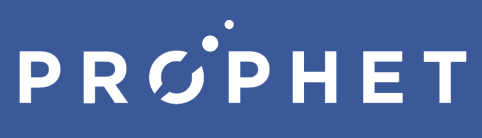

# Setup

In [1]:
#conda create --name pyprophet python=3.6
#source activate pyprophet
#conda install -c conda-forge pandas numpy scikit-learn matplotlib seaborn fbprophet 
#conda install jupyter jupyter_contrib_nbextensions nb_conda 

In [ ]:
#!conda install fbprophet --yes
#!conda list | grep prophet
#Make sure you get 0.4.post2 <- Errors about 26 columns in 0.3

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn

from ipywidgets import interact

from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot 
from fbprophet.plot import plot_cross_validation_metric
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

from statsmodels.tools.eval_measures import rmse
from statsmodels.tools.eval_measures import meanabs

# Data

In [2]:
!kaggle datasets download -d AnalyzeBoston/crimes-in-boston -p ./boston-crimes
!unzip -o ./boston-crimes/crimes-in-boston.zip -d ./boston-crimes

/bin/sh: kaggle: command not found
Archive:  ./boston-crimes/crimes-in-boston.zip
  inflating: ./boston-crimes/crime.csv  
  inflating: ./boston-crimes/offense_codes.csv  


In [3]:
df = pd.read_csv('./boston-crimes/crime.csv', encoding='ISO-8859-1')

In [4]:
df.head()

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
0,I182070945,619,Larceny,LARCENY ALL OTHERS,D14,808,NaN,2018-09-02 13:00:00,2018,9,Sunday,13,Part One,LINCOLN ST,42.357791,-71.139371,"(42.35779134, -71.13937053)"
1,I182070943,1402,Vandalism,VANDALISM,C11,347,NaN,2018-08-21 00:00:00,2018,8,Tuesday,0,Part Two,HECLA ST,42.306821,-71.060300,"(42.30682138, -71.06030035)"
2,I182070941,3410,Towed,TOWED MOTOR VEHICLE,D4,151,NaN,2018-09-03 19:27:00,2018,9,Monday,19,Part Three,CAZENOVE ST,42.346589,-71.072429,"(42.34658879, -71.07242943)"
3,I182070940,3114,Investigate Property,INVESTIGATE PROPERTY,D4,272,NaN,2018-09-03 21:16:00,2018,9,Monday,21,Part Three,NEWCOMB ST,42.334182,-71.078664,"(42.33418175, -71.07866441)"
4,I182070938,3114,Investigate Property,INVESTIGATE PROPERTY,B3,421,NaN,2018-09-03 21:05:00,2018,9,Monday,21,Part Three,DELHI ST,42.275365,-71.090361,"(42.27536542, -71.09036101)"


In [5]:
df.dtypes

INCIDENT_NUMBER         object
OFFENSE_CODE             int64
OFFENSE_CODE_GROUP      object
OFFENSE_DESCRIPTION     object
DISTRICT                object
REPORTING_AREA          object
SHOOTING                object
OCCURRED_ON_DATE        object
YEAR                     int64
MONTH                    int64
DAY_OF_WEEK             object
HOUR                     int64
UCR_PART                object
STREET                  object
Lat                    float64
Long                   float64
Location                object
dtype: object

# Data Cleaning

In [6]:
df['OCCURRED_ON_DATE'] = pd.to_datetime(df['OCCURRED_ON_DATE'])
df.index = df['OCCURRED_ON_DATE']
df.head()

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
OCCURRED_ON_DATE,,,,,,,,,,,,,,,,,
2018-09-02 13:00:00,I182070945,619,Larceny,LARCENY ALL OTHERS,D14,808,NaN,2018-09-02 13:00:00,2018,9,Sunday,13,Part One,LINCOLN ST,42.357791,-71.139371,"(42.35779134, -71.13937053)"
2018-08-21 00:00:00,I182070943,1402,Vandalism,VANDALISM,C11,347,NaN,2018-08-21 00:00:00,2018,8,Tuesday,0,Part Two,HECLA ST,42.306821,-71.060300,"(42.30682138, -71.06030035)"
2018-09-03 19:27:00,I182070941,3410,Towed,TOWED MOTOR VEHICLE,D4,151,NaN,2018-09-03 19:27:00,2018,9,Monday,19,Part Three,CAZENOVE ST,42.346589,-71.072429,"(42.34658879, -71.07242943)"
2018-09-03 21:16:00,I182070940,3114,Investigate Property,INVESTIGATE PROPERTY,D4,272,NaN,2018-09-03 21:16:00,2018,9,Monday,21,Part Three,NEWCOMB ST,42.334182,-71.078664,"(42.33418175, -71.07866441)"
2018-09-03 21:05:00,I182070938,3114,Investigate Property,INVESTIGATE PROPERTY,B3,421,NaN,2018-09-03 21:05:00,2018,9,Monday,21,Part Three,DELHI ST,42.275365,-71.090361,"(42.27536542, -71.09036101)"


In [7]:
crimeDF = df[['INCIDENT_NUMBER']].resample(rule='H').count()
crimeDF.columns=['Count']
crimeDF.head()

,Count
OCCURRED_ON_DATE,
2015-06-15 00:00:00,14
2015-06-15 01:00:00,10
2015-06-15 02:00:00,7
2015-06-15 03:00:00,3
2015-06-15 04:00:00,1


Text(0.5, 1.0, 'Boston Total Crimes by Day')

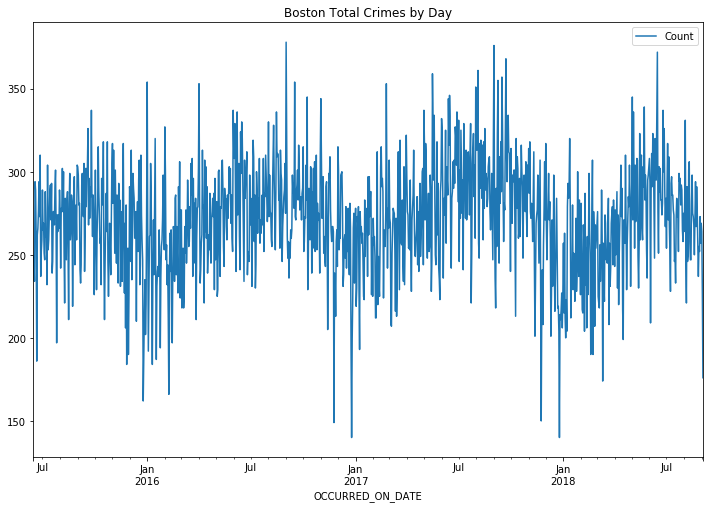

In [8]:
crimeDF.resample(rule='D').sum().plot(figsize=(12,8));
plt.title('Boston Total Crimes by Day')

# Prophet
* https://peerj.com/preprints/3190.pdf
* Forecastng Procedure in both Python and R
* Automated forecasting with tuning
* Additive models with non-linear trends
* Multiple seasonality (yearly, weekly, daily)
* Holiday effects
* Robust missing data and shifts (change points)
* Internally, they're using Stan 
    * Bayesian inference
    * MCMC Sampling (Markov Chain Monte Carlo)
    * NUTS - No U-Turn Sampler
    * Rethinking Statistics - Richard McElreath

# Forecast

## Data Setup

In [12]:
pDF = crimeDF.resample(rule='D').sum()
pDF['ds'] = pDF.index
pDF = pDF.rename(columns={'Count':'y'})
pDF.head()

,y,ds
OCCURRED_ON_DATE,,
2015-06-15,249,2015-06-15
2015-06-16,249,2015-06-16
2015-06-17,234,2015-06-17
2015-06-18,294,2015-06-18
2015-06-19,289,2015-06-19


## Fit Model

In [13]:
model = Prophet()
model.fit(pDF)

/Users/wilsons/anaconda3/envs/pyprophet/lib/python3.6/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


## Forecast
* To forecast we make a data frame of our future points
* Then we predict that data frame filling in confidence intervals & point estimate

In [14]:
future = model.make_future_dataframe(periods=365)
future

,ds
0,2015-06-15
1,2015-06-16
2,2015-06-17
3,2015-06-18
4,2015-06-19
...,...
1537,2019-08-30
1538,2019-08-31
1539,2019-09-01
1540,2019-09-02


In [15]:
forecasted = model.predict(future)

In [16]:
forecasted.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-06-15,255.531747,247.931280,312.437126,255.531747,255.531747,22.343655,22.343655,22.343655,-0.811676,-0.811676,-0.811676,23.155332,23.155332,23.155332,0.0,0.0,0.0,277.875402
1,2015-06-16,255.593919,251.493402,318.426304,255.593919,255.593919,27.810189,27.810189,27.810189,4.974432,4.974432,4.974432,22.835757,22.835757,22.835757,0.0,0.0,0.0,283.404108
2,2015-06-17,255.656091,251.884576,318.322588,255.656091,255.656091,29.426240,29.426240,29.426240,7.044598,7.044598,7.044598,22.381642,22.381642,22.381642,0.0,0.0,0.0,285.082330
3,2015-06-18,255.718263,250.299572,315.667780,255.718263,255.718263,28.425714,28.425714,28.425714,6.620731,6.620731,6.620731,21.804984,21.804984,21.804984,0.0,0.0,0.0,284.143977
4,2015-06-19,255.780434,262.031592,327.340527,255.780434,255.780434,38.697837,38.697837,38.697837,17.577569,17.577569,17.577569,21.120268,21.120268,21.120268,0.0,0.0,0.0,294.478271


In [17]:
forecasted[['ds', 'yhat_lower', 'yhat_upper', 'yhat']]

,ds,yhat_lower,yhat_upper,yhat
0,2015-06-15,247.931280,312.437126,277.875402
1,2015-06-16,251.493402,318.426304,283.404108
2,2015-06-17,251.884576,318.322588,285.082330
3,2015-06-18,250.299572,315.667780,284.143977
4,2015-06-19,262.031592,327.340527,294.478271
...,...,...,...,...
1537,2019-08-30,237.634721,303.223124,270.661773
1538,2019-08-31,213.172397,281.828653,248.437923
1539,2019-09-01,188.143661,254.064183,221.452192
1540,2019-09-02,218.580264,284.607650,251.747488


## Plot
* Dots are actual points
* Line is our predicted value
* Bands are confidence intervals
* We can also look at components

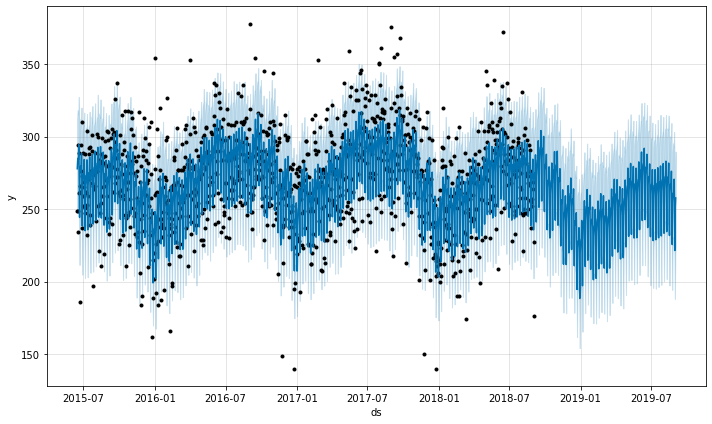

In [18]:
model.plot(forecasted);

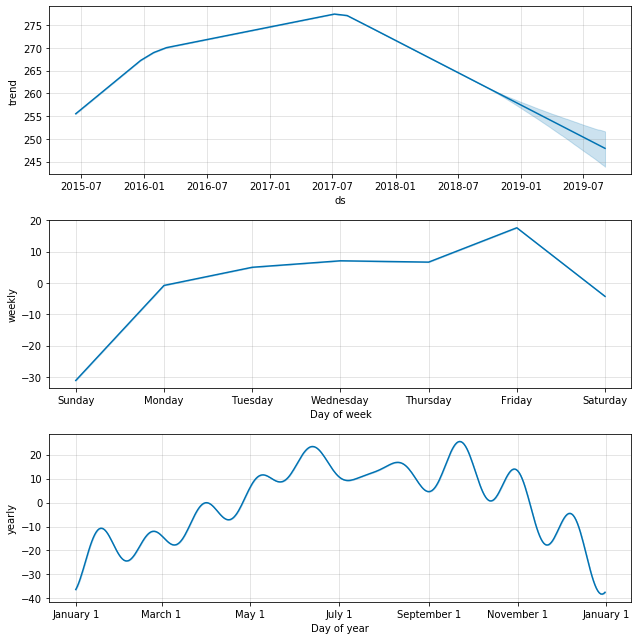

In [19]:
model.plot_components(forecasted);

# Test - Train Evaluation

## Data Setup

In [20]:
ttDF = crimeDF.resample(rule='D').sum()
ttDF['ds'] = pDF.index
ttDF = pDF.rename(columns={'Count':'y'})

train = ttDF[:1147]
test  = ttDF[1147:]

In [21]:
test.tail()

,y,ds
OCCURRED_ON_DATE,,
2018-08-30,257,2018-08-30
2018-08-31,269,2018-08-31
2018-09-01,264,2018-09-01
2018-09-02,227,2018-09-02
2018-09-03,176,2018-09-03


## Fit Model

In [22]:
model = Prophet()
model.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


## Forecast

In [23]:
future = model.make_future_dataframe(periods=30, freq='D')
forecasted = model.predict(future)

## Plot

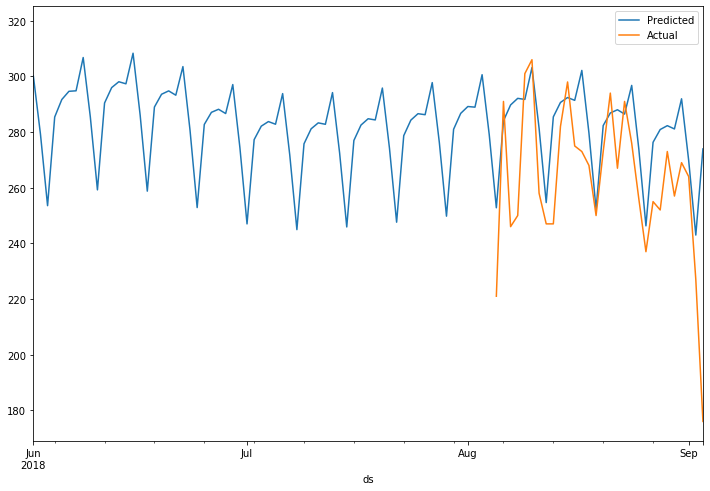

In [24]:
ax = forecasted.plot(x='ds', y='yhat', label='Predicted', legend=True, figsize=(12,8))
test.plot(x='ds', y='y', label='Actual', legend=True, ax=ax, 
          xlim=('2018-06-01', '2018-09-03'))

## Error

In [25]:
preds = forecasted.iloc[-30:]['yhat']
truth = test['y']

In [26]:
print(f'RMSE {rmse(preds, truth):.3f}')
print(f'MAE  {meanabs(preds, truth):.3f}')

RMSE 27.138
MAE  19.871


In [27]:
print(f'Percent Error {meanabs(preds, truth) / np.mean(truth) * 100.0:.3f}%')

Percent Error 7.565%


## Cross Validation
* http://facebook.github.io/prophet/docs/diagnostics.html

In [28]:
initial = f'730 days'
period  = f'365 days'
horizon = f'365 days'

cvDF = cross_validation(model, initial=initial, period=period, horizon=horizon)
cvDF

INFO:fbprophet:Making 1 forecasts with cutoffs between 2017-08-04 00:00:00 and 2017-08-04 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2017-08-05,295.000284,262.323138,326.161913,257,2017-08-04
1,2017-08-06,268.432387,235.814602,299.870106,248,2017-08-04
2,2017-08-07,300.681596,269.058967,334.392144,317,2017-08-04
3,2017-08-08,304.549099,270.265273,336.221424,290,2017-08-04
4,2017-08-09,306.949225,274.338320,339.804761,319,2017-08-04
...,...,...,...,...,...,...
360,2018-07-31,316.708628,283.307720,348.414437,275,2017-08-04
361,2018-08-01,319.171008,286.314892,351.441051,264,2017-08-04
362,2018-08-02,318.639180,287.917341,350.285035,282,2017-08-04
363,2018-08-03,329.388688,297.619879,364.172059,331,2017-08-04


In [29]:
performance_metrics(cvDF)

,horizon,mse,rmse,mae,mape,coverage
35,36 days,796.250071,28.217903,22.399237,0.080141,0.805556
36,37 days,767.602276,27.705636,21.907980,0.078337,0.833333
37,38 days,759.216476,27.553883,21.639065,0.077015,0.833333
38,39 days,765.117503,27.660757,21.793550,0.077748,0.833333
39,40 days,763.166776,27.625473,21.719777,0.077393,0.833333
...,...,...,...,...,...,...
360,361 days,1200.201921,34.643931,30.064047,0.112447,0.611111
361,362 days,1281.398204,35.796623,31.291305,0.117234,0.583333
362,363 days,1313.578290,36.243321,31.932319,0.119688,0.555556
363,364 days,1299.036775,36.042153,31.339948,0.117611,0.555556


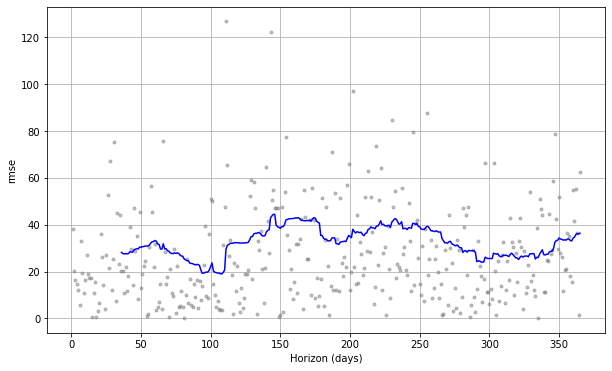

In [30]:
plot_cross_validation_metric(cvDF, metric='rmse');

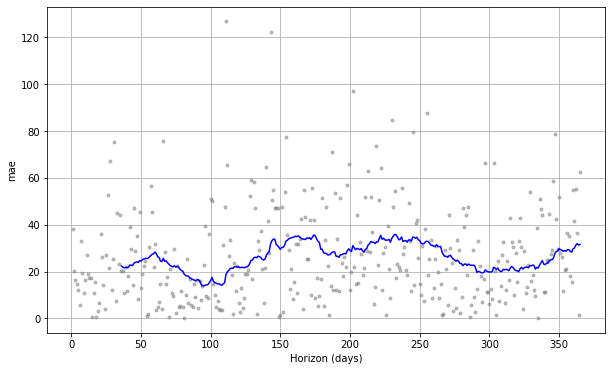

In [31]:
plot_cross_validation_metric(cvDF, metric='mae');

# Holidays
* Holidays can include meaningful days (sales or events)

In [32]:
christmas = ['2015-12-24', '2015-12-25', 
             '2016-12-24', '2016-12-25',
             '2017-12-24', '2017-12-25',
             '2018-12-24', '2018-12-25']
new_years = ['2015-12-31', '2016-01-01',
             '2016-12-31', '2017-01-01',
             '2017-12-31', '2018-01-01',
             '2018-12-31', '2019-01-01']
four_jul  = ['2015-07-04', '2016-07-04',
             '2017-07-04', '2018-07-04']
st_pat    = ['2015-03-17', '2016-03-17',
             '2017-03-17', '2018-03-17']

holidays = christmas + new_years + four_jul + st_pat
holidaysDF = pd.DataFrame(holidays, columns=['ds'])
holidaysDF['holiday'] = 'Holiday'
holidaysDF['ds'] = pd.to_datetime(holidaysDF.ds)
holidaysDF

,ds,holiday
0,2015-12-24,Holiday
1,2015-12-25,Holiday
2,2016-12-24,Holiday
3,2016-12-25,Holiday
4,2017-12-24,Holiday
5,2017-12-25,Holiday
6,2018-12-24,Holiday
7,2018-12-25,Holiday
8,2015-12-31,Holiday
9,2016-01-01,Holiday


## Fit Model

In [33]:
model = Prophet(holidays=holidaysDF)
model.fit(pDF)
future = model.make_future_dataframe(periods=30, freq='D')
forecasted = model.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


## Plot

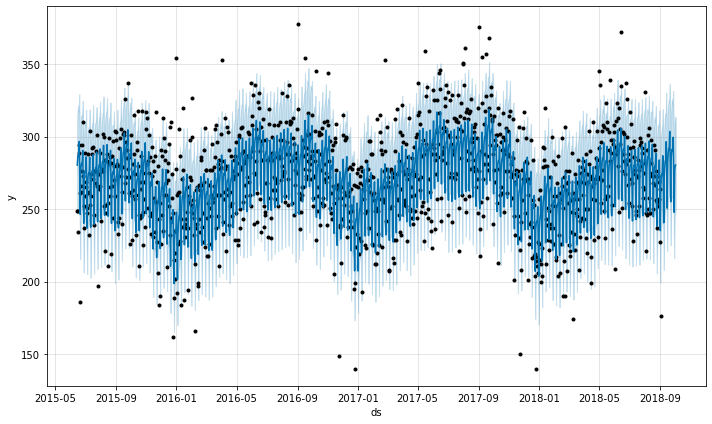

In [34]:
fig = model.plot(forecasted)

## Components
* Given the scale of components, holidays aren't very meaningful

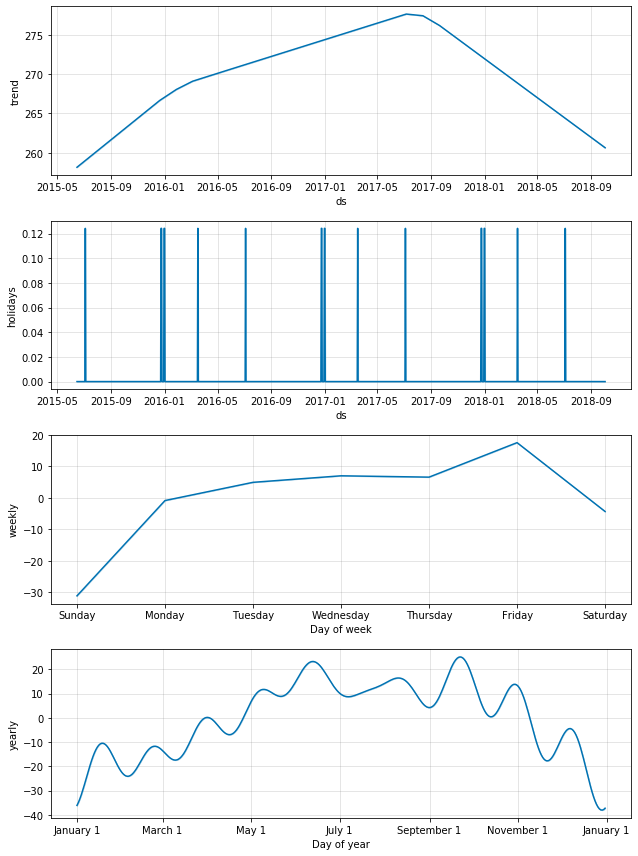

In [35]:
model.plot_components(forecasted);

# Trend Changes

In [36]:
model = Prophet()
model.fit(pDF)
future = model.make_future_dataframe(periods=30, freq='D')
forecasted = model.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


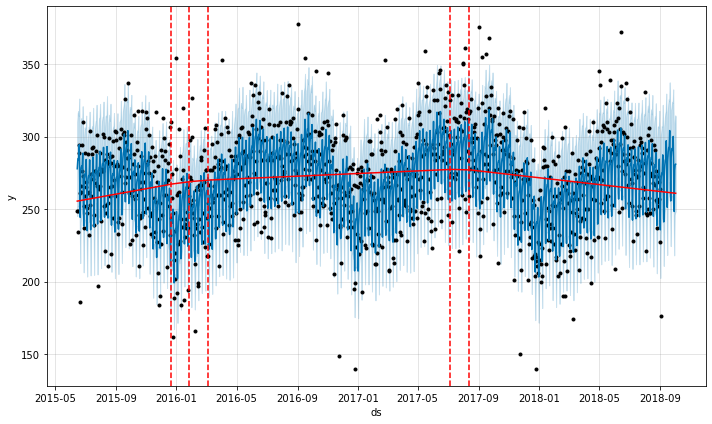

In [37]:
fig = model.plot(forecasted)
added = add_changepoints_to_plot(fig.gca(), model, forecasted)

## Manual Changepoints
* If we set a change point, we can control the knots of a piece-wise fitting
* Assume we saw a regime change in 2017

In [38]:
model = Prophet(changepoints=['2017-01-01'])
model.fit(pDF)
future = model.make_future_dataframe(periods=30, freq='D')
forecasted = model.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


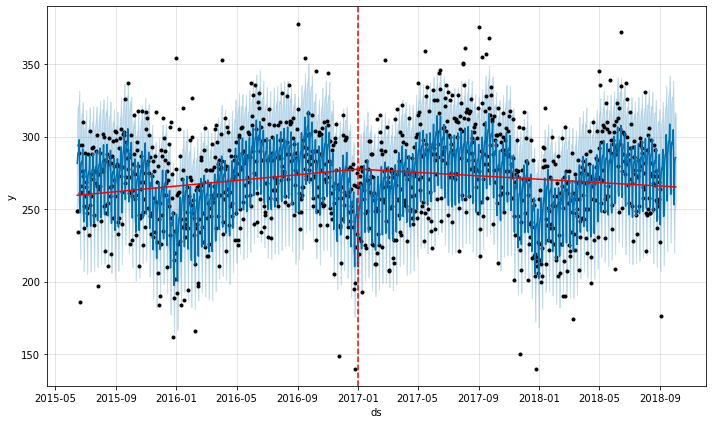

In [39]:
fig = model.plot(forecasted)
added = add_changepoints_to_plot(fig.gca(), model, forecasted)

# Seasonal Uncertainty
* Uncertainty reported in trend and observation

In [40]:
model = Prophet(mcmc_samples=300)
model.fit(pDF)
future = model.make_future_dataframe(periods=30, freq='D')
forecasted = model.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


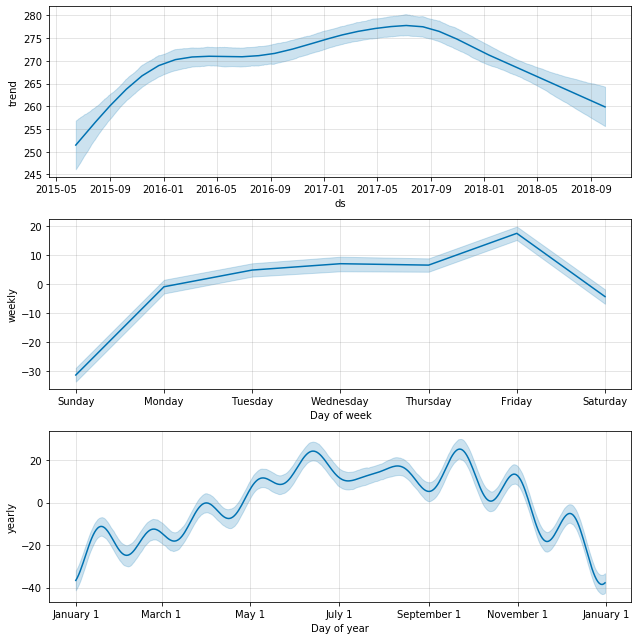

In [41]:
model.plot_components(forecasted);

# Hourly Forecasts
* Includes daily seasonality

## Data Setup

In [42]:
hourlyDF = crimeDF.copy()
hourlyDF['ds'] = hourlyDF.index
hourlyDF = hourlyDF.rename(columns={'Count':'y'})

## Fit Model

In [43]:
model = Prophet()
model.fit(hourlyDF)

## Forecast

In [44]:
future = model.make_future_dataframe(periods=30*24, freq='H')
forecasted = model.predict(future)

## Plot

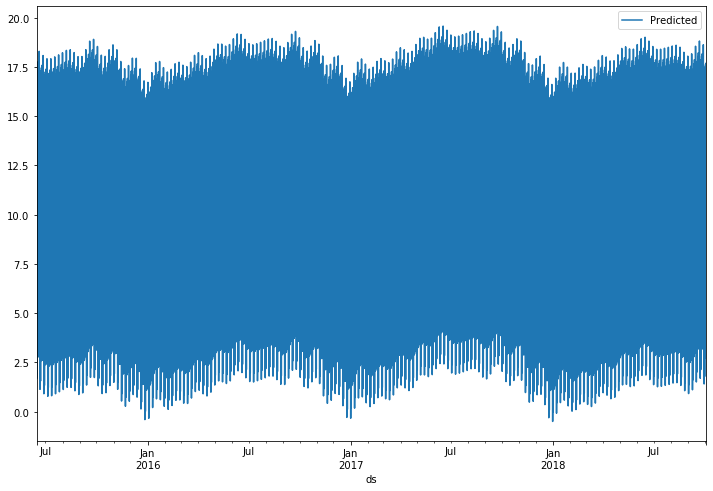

In [45]:
forecasted.plot(x='ds', y='yhat', label='Predicted', legend=True, figsize=(12,8), )

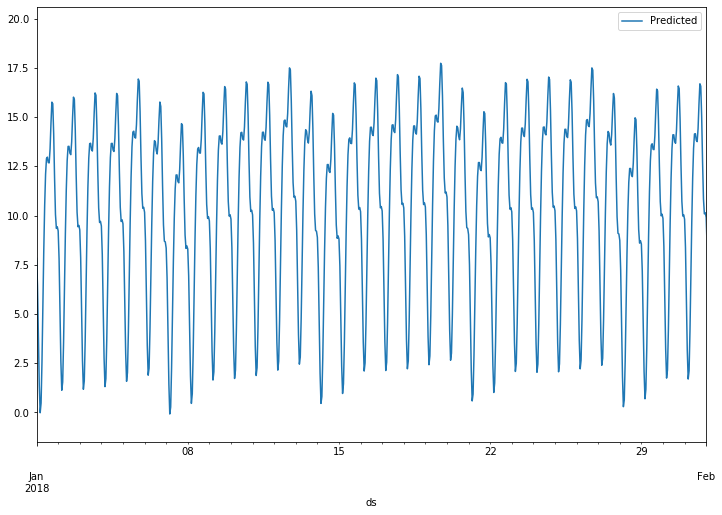

In [49]:
forecasted.plot(x='ds', y='yhat', label='Predicted', legend=True, figsize=(12,8), xlim=('2018-01-01', '2018-02-01'))

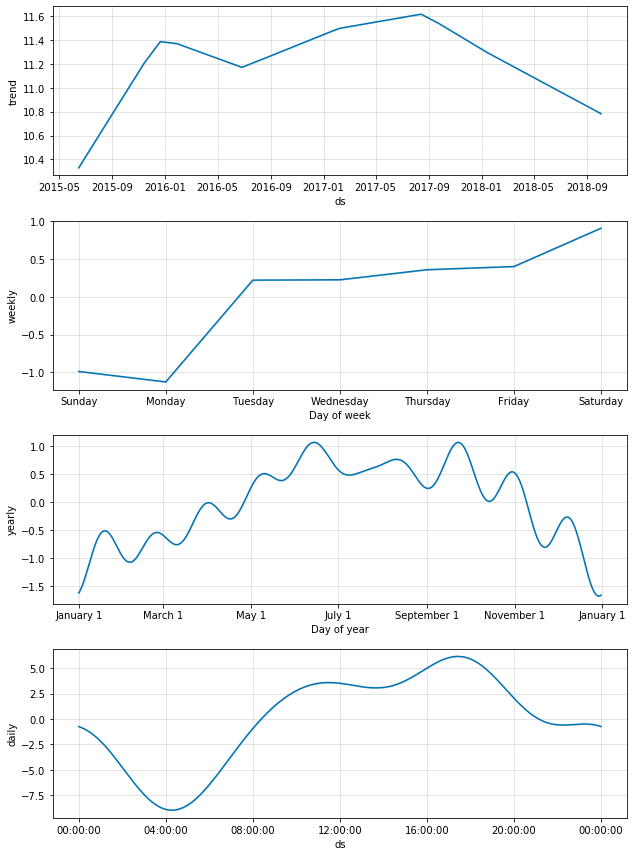

In [117]:
model.plot_components(forecasted);

# Crime By Offense

In [50]:
offenses = df['OFFENSE_CODE_GROUP'].unique().tolist()

@interact
def crimeByOffense(offense=offenses):
    offDF = df[df.OFFENSE_CODE_GROUP == offense][['OFFENSE_CODE']]
    offDF = offDF.resample(rule='D').count()
    offDF['ds'] = pDF.index
    offDF = offDF.rename(columns={'OFFENSE_CODE':'y'})
    
    model = Prophet()
    model.fit(offDF)
    
    future = model.make_future_dataframe(periods=365)
    forecasted = model.predict(future)
    model.plot(forecasted);

interactive(children=(Dropdown(description='offense', options=('Larceny', 'Vandalism', 'Towed', 'Investigate P…

# Conclusion
* Prophet is solid!
* Avilable in R and Python
* Strong in modeling with multiple seasonality
* Includes cross-validation techniques
* Good plotting to aid with communication
* Holiday / Important Dates (Exogenous)
* Change point modeling is great
* Add it to your toolkit & check their paper